In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

import IPython.display as ipd
from IPython.display import clear_output

from librosa import power_to_db, load
from librosa.feature import melspectrogram, mfcc
from librosa.effects import trim
import librosa.display

from os import listdir
from os.path import join, exists

from scipy.io import wavfile
from scipy import signal
from scipy.stats import zscore

from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn import svm
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, ParameterGrid
from sklearn.decomposition import PCA
from sklearn.dummy import DummyClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import warnings
warnings.simplefilter("ignore")

# Exploratory data analysis - Tabular dataset

## Data Cleaning

In [2]:
df_orig = pd.read_csv("dsl_data/development.csv")
df_orig.columns = ['Id', 'path', 'speakerId', 'action', 'object',
       'fluency_level', 'first_language',
       'current_language', 'gender', 'ageRange']
df_orig.loc[ df_orig.action == "change language", "object"] = "language"
df_orig.loc[ df_orig.action == "change language", "action"] = "change"
df_orig.head()


,Id,path,speakerId,action,object,fluency_level,first_language,current_language,gender,ageRange
0,0,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/0a312...,2BqVo8kVB2Skwgyb,change,language,advanced,English (United States),English (United States),female,22-40
1,1,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/0ee42...,2BqVo8kVB2Skwgyb,activate,music,advanced,English (United States),English (United States),female,22-40
2,2,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/1d9f3...,2BqVo8kVB2Skwgyb,deactivate,lights,advanced,English (United States),English (United States),female,22-40
3,3,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/269fc...,2BqVo8kVB2Skwgyb,increase,volume,advanced,English (United States),English (United States),female,22-40
4,4,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/5bbda...,2BqVo8kVB2Skwgyb,increase,volume,advanced,English (United States),English (United States),female,22-40


In [3]:
# Dataset has no NaN values
print(df_orig.isna().sum())

Id                  0
path                0
speakerId           0
action              0
object              0
fluency_level       0
first_language      0
current_language    0
gender              0
ageRange            0
dtype: int64


<AxesSubplot: xlabel='first_language', ylabel='Count'>

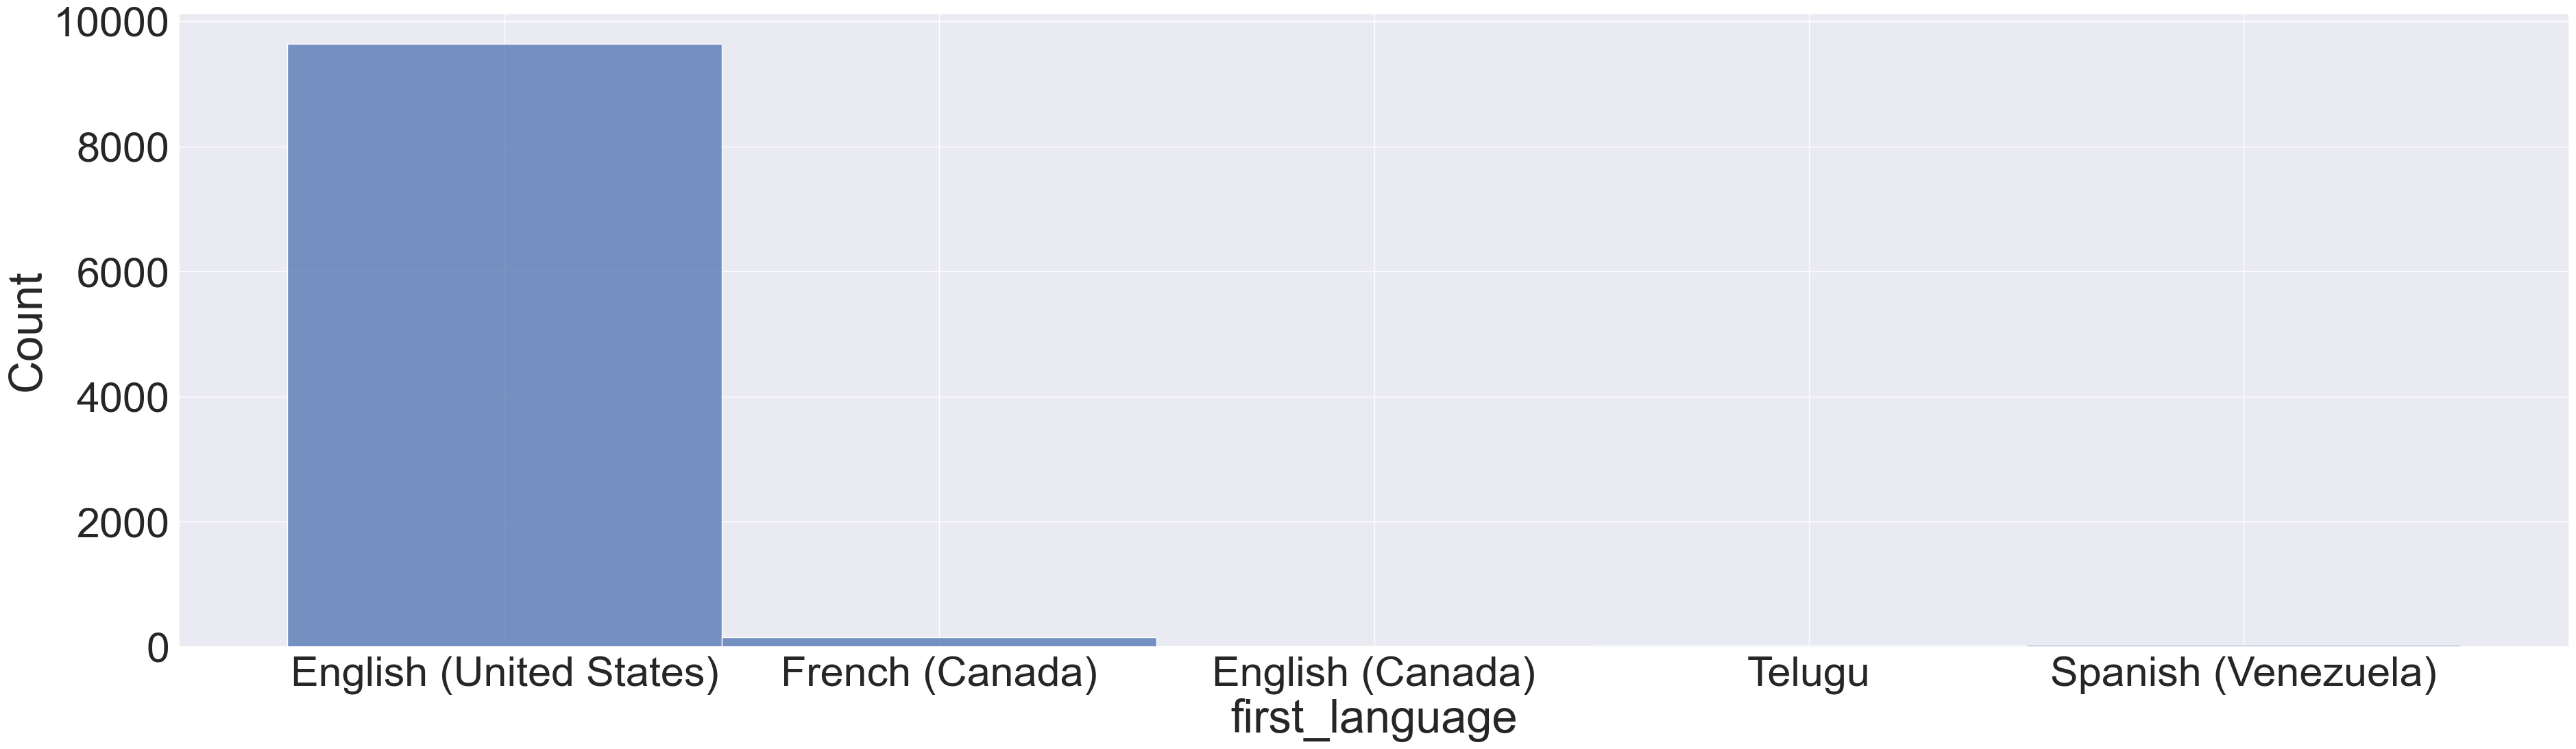

In [4]:
sns.set(rc={'figure.figsize':(45,12)})
sns.set(font_scale=4)
a = df_orig.first_language ### Change to see the other features distribution
sns.histplot(a)

<AxesSubplot: ylabel='Count'>

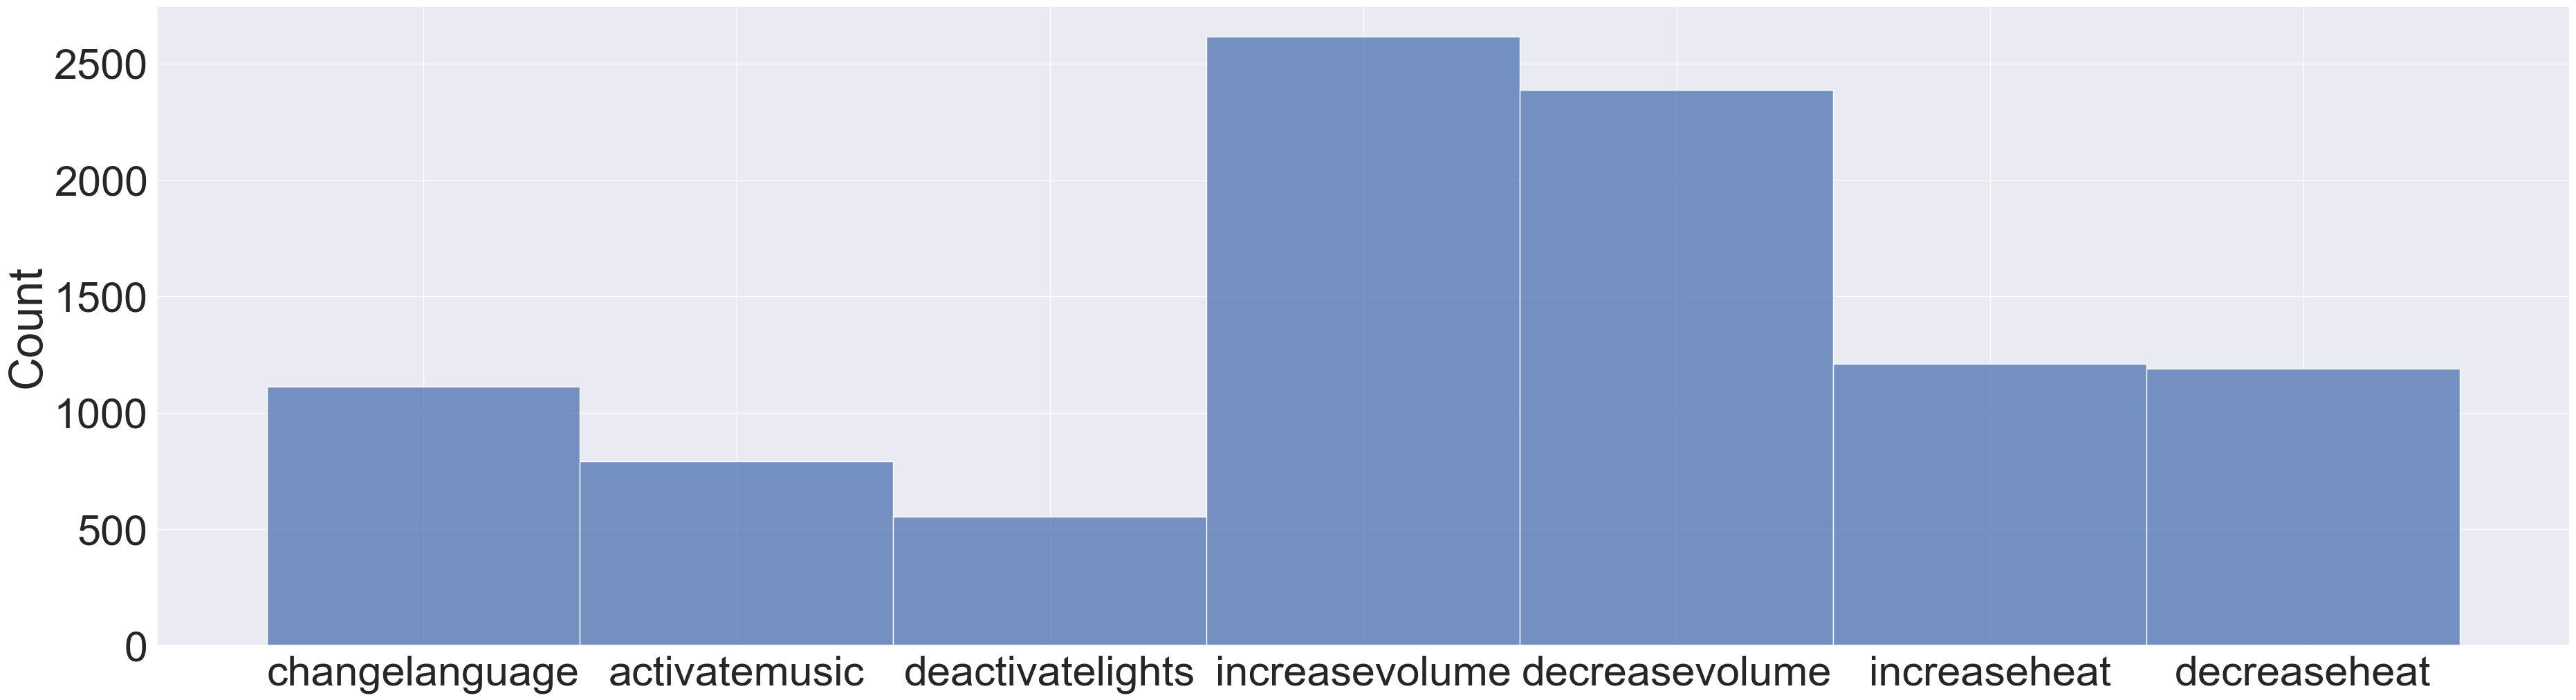

In [5]:
# Dataset target feature distribution -> May need augmentation ?
a = df_orig.action + df_orig.object
sns.histplot(a)

In [6]:
df = df_orig[(df_orig.fluency_level == "native") | (df_orig.fluency_level == "advanced")]
df = df[df.current_language == "English (United States)"]
df = df[df.first_language == "English (United States)"]
print(df_orig.shape)
print(df.shape)

y = df[["action","object"]]

(9854, 10)
(9521, 10)


# Exploratory data analysis - Audio dataset

### Length distribution

In [7]:
wav_files = []
wav_freq = []

for i in range(len(df)):
    wav_f, wav_arr = wavfile.read(df.iloc[i].path)
    wav_files.append(wav_arr)
    wav_freq.append(wav_f)

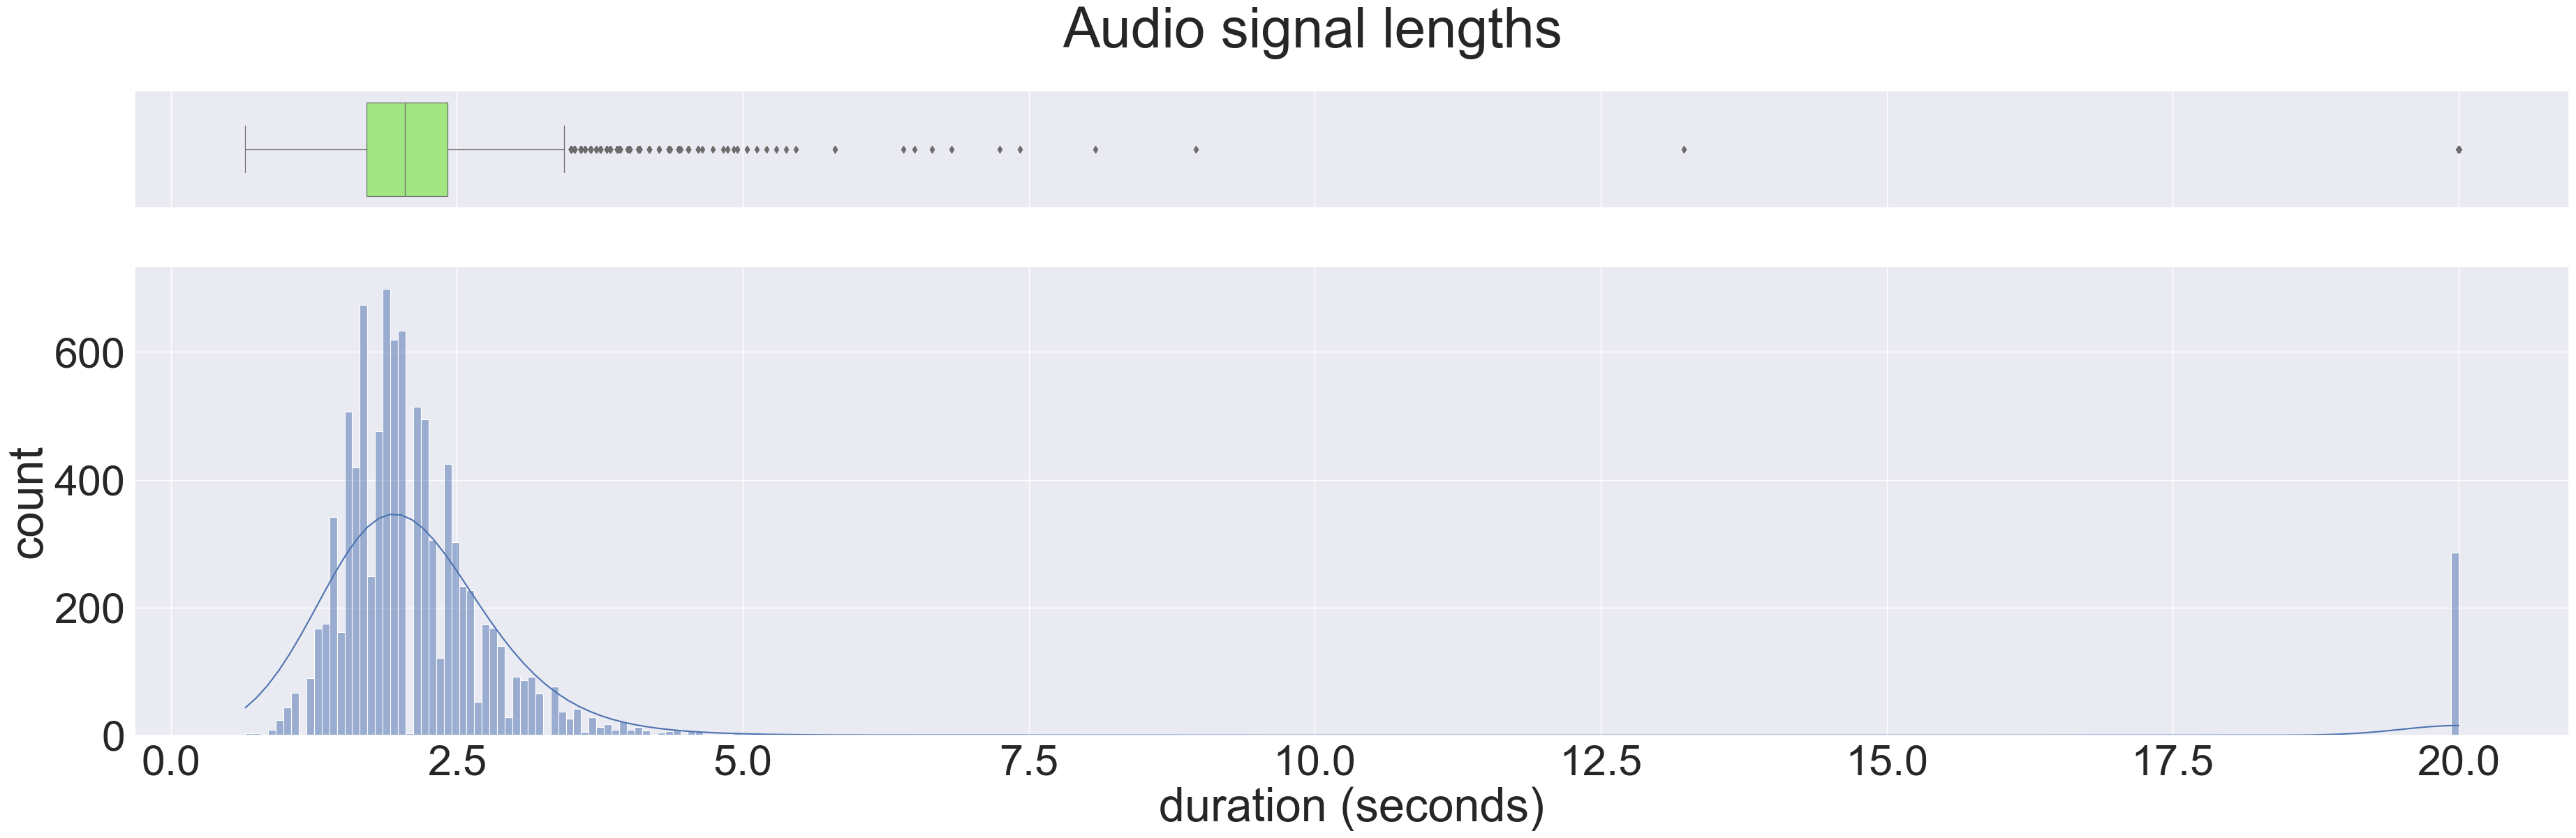

In [8]:
def show_length_distribution(signals, rates):
    sampel_times = [len(signals[i])/rates[i] for i in range(len(signals))]


    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.20, .80)})

    # Add a graph in each part
    sns.boxplot(x = sampel_times, ax=ax_box, linewidth = 0.9, color=  '#9af772')
    sns.histplot(x = sampel_times, ax=ax_hist, bins = 'fd', kde = True)

    # Remove x axis name for the boxplot
    ax_box.set(xlabel='')


    title = 'Audio signal lengths'
    x_label = 'duration (seconds)'
    y_label = 'count'

    plt.suptitle(title)
    ax_hist.set_xlabel(x_label)
    ax_hist.set_ylabel(y_label)
    plt.show()
    return sampel_times

lengths = show_length_distribution(wav_files, wav_freq)

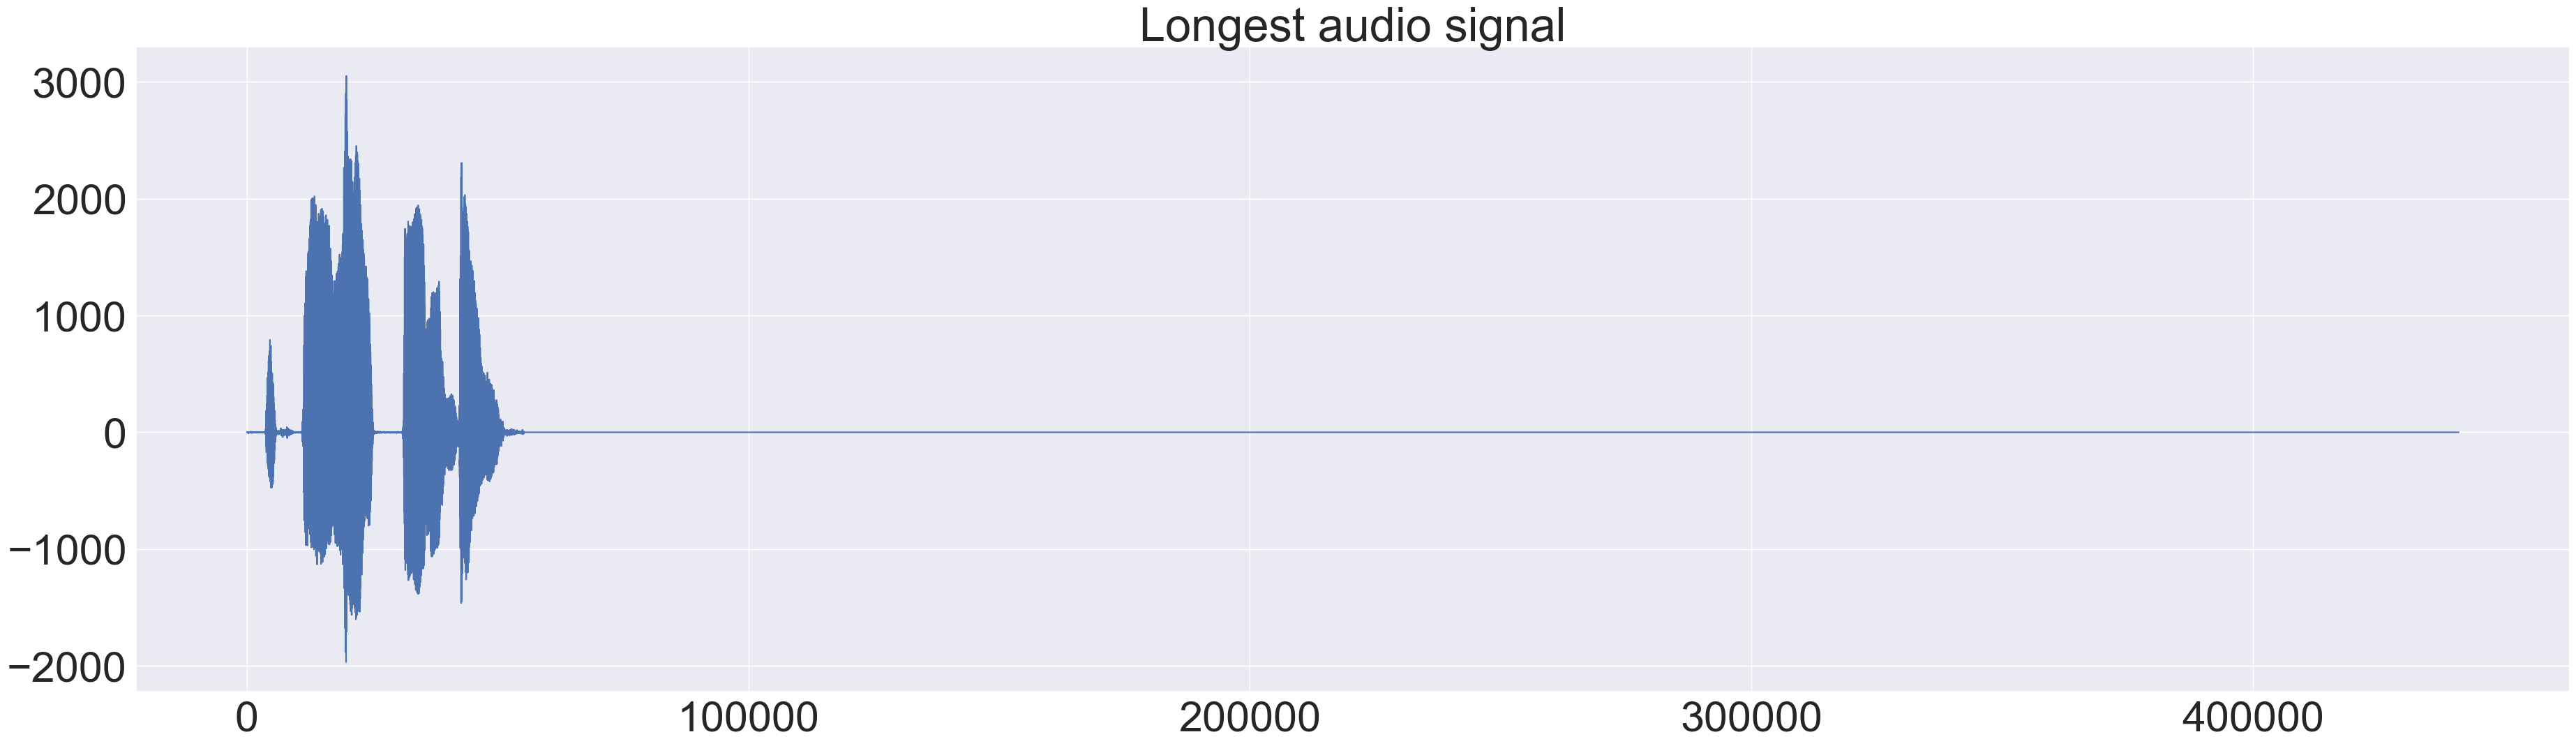

In [9]:
Longest_audio = np.argmax(lengths)
plt.plot(wav_files[Longest_audio])
plt.title("Longest audio signal");

ipd.Audio(wav_files[Longest_audio], rate=wav_freq[Longest_audio])


Text(0.5, 1.0, 'Standard deviation of audio signals')

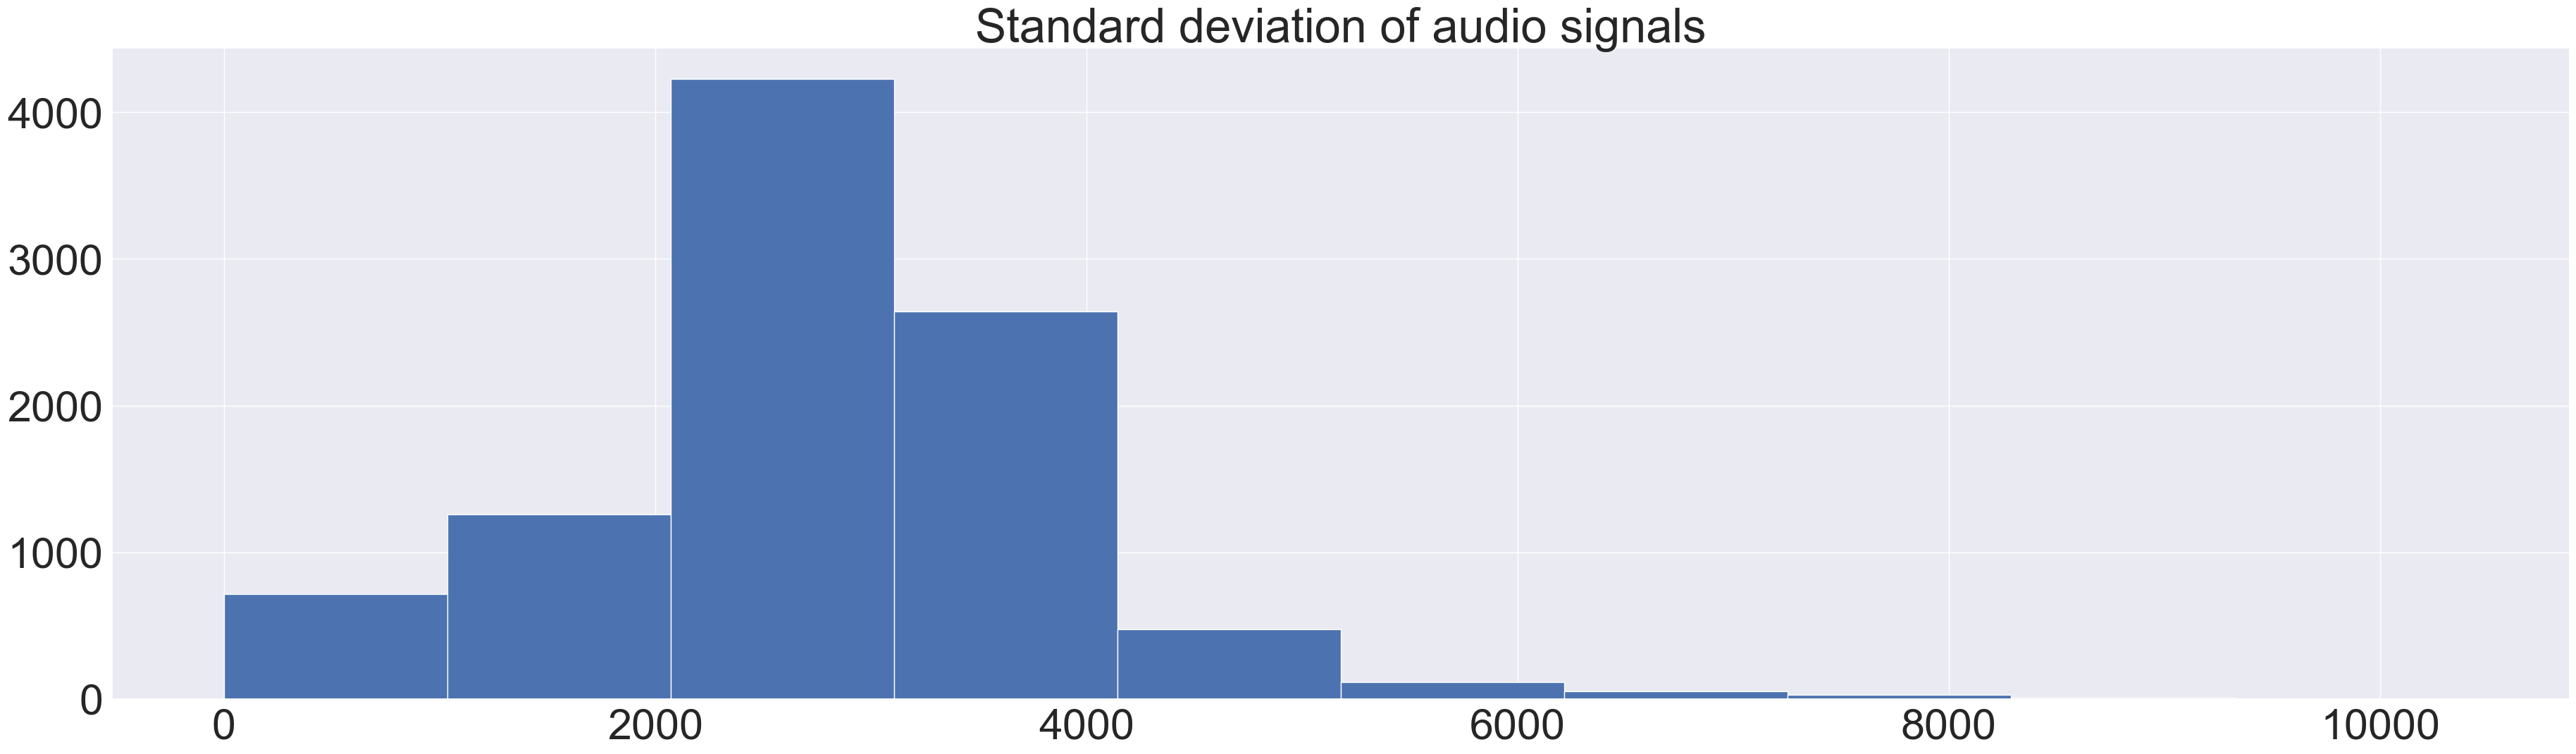

In [10]:
stdv = [np.std(x) for x in wav_files]
plt.hist(stdv)
plt.title("Standard deviation of audio signals")

# Data preprocessing - Audio

In [72]:
def remove_silence(sample, sr= 8000, top_db = 20):
    """
    This function removes silence periods of audio signals.
    """
    y = np.array(sample, dtype = np.float64)
    # Trim the beginning and ending silence
    yt, _ = trim(y, top_db= top_db)
    return yt

def normalize_data(sample):
    """This function normalizes the audio signal"""
    return zscore(sample)

def resample_data(sample, old_sampling_rate, new_sampling_rate):
    """This function resamples the audio signal"""
    number_of_samples = round(len(sample) * float(new_sampling_rate) / old_sampling_rate)
    return np.array( signal.resample(sample, number_of_samples) )


def preprocess(data, y, sample_rates, quantile_filter=True):
    """This function uses the functions: 'resample_data', 'normalize_data' and 'remove_silence' in order to preprocess the audiofiles
    At the end it only keeps the audios having length within the 95% quartile
    """
    pp_data = []
    new_sample_rate = min(sample_rates)
    
    # Resample, normalize, trim
    for i in range(len(wav_files)):
        sample = wav_files[i]
        sample_rate = wav_freq[i]
        
        resampled_data = resample_data(sample, sample_rate, new_sample_rate)
        normalized_data = normalize_data(resampled_data)
        trimmed_data = remove_silence(normalized_data, sr=new_sample_rate)
    

        pp_data.append( np.array(trimmed_data) )
    
    if quantile_filter:
        # Clean all the lengths < q_0.95
        lengths = [len(x) for x in pp_data]
        q = np.quantile(lengths, 0.95)
        ok = [True if (l <= q) else False for l in lengths]
        X = np.array(pp_data)[ok]
        y_new = np.array(y)[ok]
    else:
        X = np.array(pp_data)
        y_new = np.array(y)
        ok = None
    
    
    return X, y_new, new_sample_rate , ok  

In [12]:
audio_trimmed, y, sr, ok = preprocess(wav_files, y, wav_freq)

In [13]:
# Define the preprocessed time domain dataset
X = np.array(audio_trimmed)
print(f"X shape:{X.shape} (np.array of objects being also np.array)")
print(max([len(x)/sr for x in X]))

# Save clean df to train dummyClassifier
df[ok].to_csv("preprocess/df_ok.csv", index=False)

# Define the target features (save y into a DF just in case)
pd.DataFrame(y).to_csv("preprocess/y.csv")
y_act = y[:,0]
y_obj = y[:,1]

X shape:(9081,) (np.array of objects being also np.array)
1.92


### Random audio postprocessed

In [14]:
def plot_audio(sample, freq):
    # Plots
    fig, axs = plt.subplots(1,2, figsize=(15, 5))

    axs[0].plot(sample)
    axs[0].set_title("Processed audio signal")

    powerSpectrum, freqenciesFound, time, imageAxis = plt.specgram(sample, Fs=freq, scale = "dB", cmap="viridis")
    cbar = plt.gcf().colorbar(imageAxis)
    cbar.set_label('db')
    
    axs[1].set_title("Spectrogram of a signal")
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('Frequency')
    
    axs[1].grid()
    plt.show()

Id                                                               9118
path                dsl_data/audio/speakers/D4jGxZ7KamfVo4E2V/a643...
speakerId                                           D4jGxZ7KamfVo4E2V
action                                                       decrease
object                                                           heat
fluency_level                                                  native
first_language                                English (United States)
current_language                              English (United States)
gender                                                         female
ageRange                                                        22-40
Name: 9118, dtype: object


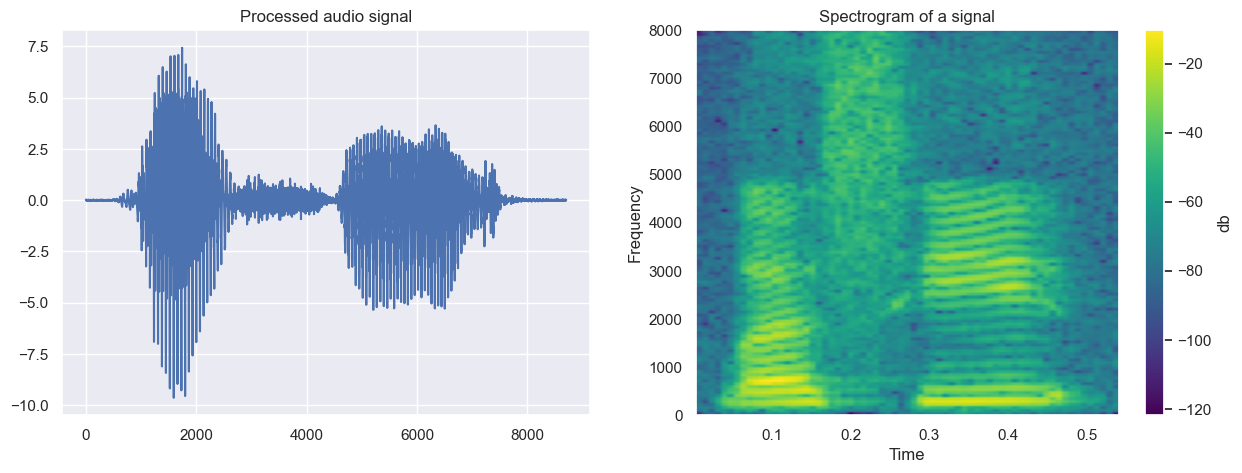

In [15]:
sns.set(rc={'figure.figsize':(15,12)})
sns.set(font_scale=1)
a = random.randint(0, len(audio_trimmed))

# Audio player & info
print(df[ok].iloc[a])
ipd.display(ipd.Audio(X[a], rate=wav_freq[a]))

plot_audio(audio_trimmed[a], sr)

# Feature extraction

In [16]:
ns = list(range(6,44,3))

### Spectogram extraction

In [17]:
def ft_mean_std(X, n, f_s=8000):
    """Computes mean and std of each block of the spectrogram of X
       empty bins contains mean values of that column matrices
    """
    X_sp = []  # feature matrix
    n_audio = len(X)
    for i, x in enumerate(X):
        if i % 1 == 0:
            clear_output(wait=True)
            print(f"[{n}] {(i / (n_audio - 1)) * 100:.4} %")

        sp = power_to_db(melspectrogram(x, n_fft=len(x)), np.mean)
        x_sp = get_sample_features(sp, n)
        X_sp.append(x_sp)

    return np.array(X_sp)

def get_sample_features(sp, n):
    x_sp = np.empty((2 * n * n))  # current feature set
    i = 0

    # split the rows
    for v_split in np.array_split(sp, n, axis=0):
        # split the columns
        for h_split in np.array_split(v_split, n, axis=1):
            if h_split.size == 0:  # happens when number of culumns < n
                m = np.median(v_split).__round__(4)
                sd = np.std(v_split).__round__(4)
            else:
                m = np.mean(h_split).__round__(4)
                sd = np.std(h_split).__round__(4)

            x_sp[i] = m
            x_sp[i + 1] = sd
            i += 2
    return x_sp

In [18]:
print("Object-classifier accuracy for [n] splits considering only log-Mel spectogram!")
print("Results are only indicative -> Final considerations will be made using Cross-Validation")

rs = 99

models = {
    "rfc": RFC(random_state=rs),
    "svm": Pipeline([('scaler', StandardScaler()), ('SVM', svm.SVC())])
}

scores = {}
for n in ns:
    path_to_file = f"preprocess/freq_n/{n}_bins.csv"
    if exists(path_to_file):
        X_ft = pd.read_csv(path_to_file)
    else:
        X_ft = ft_mean_std(X, n)
        pd.DataFrame(X_ft).to_csv(path_to_file)
        
    X_train, X_test, y_train, y_test = train_test_split(X_ft, y_obj, test_size = 0.20, random_state = rs)
    score = []
    for model in models:
        clf = models[model]
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        a = accuracy_score(y_test, y_pred)
        score.append((model, a))
    scores[n] = score
    
    print(f"[{n}]: ",score)
    

### THIS RESULTS ARE ONLY INDICATIVE
### THE FINAL RESULTS AND CONSIDERATIONS WILL BE MADE USING CROSS-VALIDATION

Object-classifier accuracy for [n] splits considering only log-Mel spectogram!
Results are only indicative -> Final considerations will be made using Cross-Validation
[6]:  [('rfc', 0.7616951018161805), ('svm', 0.8150798018712163)]
[9]:  [('rfc', 0.7721518987341772), ('svm', 0.8354430379746836)]
[12]:  [('rfc', 0.7666483214089158), ('svm', 0.833241607044579)]
[15]:  [('rfc', 0.7710511832691249), ('svm', 0.8420473307649973)]
[18]:  [('rfc', 0.7671986791414419), ('svm', 0.8464501926252064)]
[21]:  [('rfc', 0.755641166758393), ('svm', 0.8326912493120529)]
[24]:  [('rfc', 0.7567418822234453), ('svm', 0.8392955421023666)]
[27]:  [('rfc', 0.7716015410016511), ('svm', 0.8436984039625757)]
[30]:  [('rfc', 0.7671986791414419), ('svm', 0.844799119427628)]
[33]:  [('rfc', 0.7550908090258668), ('svm', 0.8425976884975234)]
[36]:  [('rfc', 0.7446340121078702), ('svm', 0.8403962575674189)]
[39]:  [('rfc', 0.7484865162355531), ('svm', 0.8354430379746836)]
[42]:  [('rfc', 0.744083654375344), ('svm', 0.

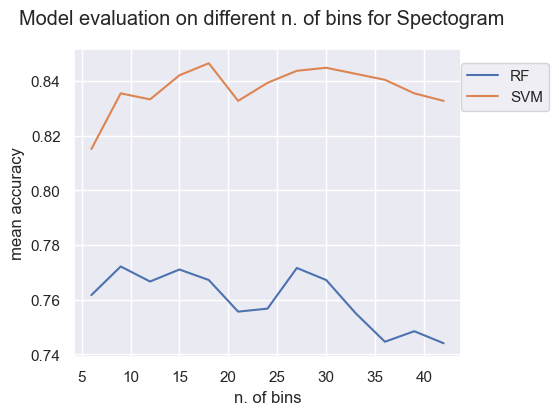

In [19]:
sns.set(rc={'figure.figsize':(5,4)})
sns.set(font_scale=1)

rf_scores = [x[0][1] for x in scores.values()]
svm_scores = [x[1][1] for x in scores.values()]
x = scores.keys()

plt.plot(x, rf_scores, label = 'RF')
plt.plot(x, svm_scores, label= 'SVM')

plt.legend(loc = (1,.8))
plt.suptitle("Model evaluation on different n. of bins for Spectogram")
plt.xlabel("n. of bins")
plt.ylabel('mean accuracy')
plt.show()

### MFCCs extraction

In [20]:
def extract_mfcc(X, n_split, sr, n_mfcc=13):
    X_mfcc_support = []
    n_audio=len(X)
    
    for i in range(len(X)):
        clear_output(wait=True)
        print(f"[{n_split}] {(i / (n_audio - 1)) * 100:.4} %")

        sample = X[i]
        
        sample_features = np.empty((2*n_mfcc*n_split))
        i_sf = 0
        
        mfccs = mfcc(sample, n_mfcc=n_mfcc, sr=sr, hop_length=max(1, len(sample)//(n_split*50)))
        
        for m in mfccs:
            m_split = np.array_split(m, n_split)
            for s in m_split:
                sample_features[i_sf] = s.mean()
                sample_features[i_sf + 1] = s.std()
                i_sf += 2
                
        X_mfcc_support.append(sample_features)

    return np.array(X_mfcc_support)

In [21]:
print("Object-classifier accuracy for [n] splits considering log-Mel spectogram and MFCC!")
print("Results are only indicative -> Final considerations will be made using Cross-Validation")

scores = {}
for n in ns:
    path_to_file = f"preprocess/mfcc_n/{n}_bins.csv"
    
    if exists(path_to_file):
        X_mfcc = pd.read_csv(path_to_file)

    else:
        X_mfcc = extract_mfcc(X, n, sr)
        pd.DataFrame(X_mfcc).to_csv(path_to_file, index=False)

    X_ft = pd.read_csv(f"preprocess/freq_n/{n}_bins.csv")
    X_tot = np.hstack((X_ft, X_mfcc))
    X_train, X_test, y_train, y_test = train_test_split(X_tot, y_obj, test_size = 0.20, random_state = rs)
    
    score = []
    for model in models:
        clf = models[model]
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        a = accuracy_score(y_test, y_pred)
        score.append((model, a))
    scores[n] = score
    print(f"[{n}] -> {score}")
    

### THIS RESULTS ARE ONLY INDICATIVE
### THE FINAL RESULTS AND CONSIDERATIONS WILL BE MADE USING CROSS-VALIDATION

Object-classifier accuracy for [n] splits considering log-Mel spectogram and MFCC!
Results are only indicative -> Final considerations will be made using Cross-Validation
[6] -> [('rfc', 0.8145294441386901), ('svm', 0.9212988442487617)]
[9] -> [('rfc', 0.8073747936158503), ('svm', 0.9174463401210787)]
[12] -> [('rfc', 0.8084755090809026), ('svm', 0.9196477710511832)]
[15] -> [('rfc', 0.7969179966978536), ('svm', 0.906989543203082)]
[18] -> [('rfc', 0.7963676389653275), ('svm', 0.9141441937259218)]
[21] -> [('rfc', 0.7936158503026968), ('svm', 0.9053384700055036)]
[24] -> [('rfc', 0.7980187121629059), ('svm', 0.9003852504127683)]
[27] -> [('rfc', 0.7859108420473307), ('svm', 0.899284534947716)]
[30] -> [('rfc', 0.7941662080352229), ('svm', 0.9003852504127683)]
[33] -> [('rfc', 0.7914144193725922), ('svm', 0.9064391854705559)]
[36] -> [('rfc', 0.7853604843148047), ('svm', 0.9036873968079252)]
[39] -> [('rfc', 0.7831590533847), ('svm', 0.899284534947716)]
[42] -> [('rfc', 0.76940011007154

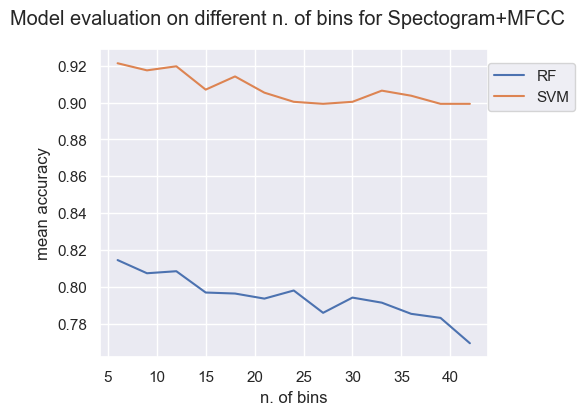

In [22]:
sns.set(rc={'figure.figsize':(5,4)})
sns.set(font_scale=1)

rf_scores = [x[0][1] for x in scores.values()]
svm_scores = [x[1][1] for x in scores.values()]
x = scores.keys()

plt.plot(x, rf_scores, label = 'RF')
plt.plot(x, svm_scores, label= 'SVM')

plt.legend(loc = (1,.8))
plt.suptitle("Model evaluation on different n. of bins for Spectogram+MFCC")
plt.xlabel("n. of bins")
plt.ylabel('mean accuracy')
plt.show()

# Hyperparameter Tuning

### Feature extraction hyperparameter tuning

In [30]:
# GENERAL [ BEST: SVM (n12, i70) -> 0.8937333771356668 ]
n_freq = list(range(6,44,3))
i_pca = [10,30,50,70,100,300,500,700]

# NEIGHBOURHOOD [ BEST: SVM (n15, i80) -> svm : 0.8956051389350215
# n_freq = list(range(9,16))
# i_pca = list(range(50,101,10))

combinations = []
for n in n_freq:
    for i in i_pca:
        combinations.append((n,i))
print(len(combinations))

104


In [31]:
y = y_obj ### CHANGE TO y_act for ACTION feature extraction hyperparameter tuning
ohe = OneHotEncoder()
X_obj = ohe.fit_transform(y_obj.reshape(-1,1)).toarray()

In [32]:
from sklearn.model_selection import cross_val_score

scores = {}
for rc in combinations:
    n, i = rc
    X_ft = pd.read_csv(f"preprocess/freq_n/{n}_bins.csv")
    X_mfcc = pd.read_csv(f"preprocess/mfcc_n/{n}_bins.csv")
    
    X_tot = np.hstack((X_ft,  X_mfcc)) ### ADD X_obj for ACTION feature extraction hyperparameter tuning
    
    if len(X_tot[0]) < i: continue
        
    pca = PCA(n_components=i)
    X_pca = pca.fit_transform(X_tot)
    
    
    score = []
    for model in models:
        clf = models[model]
        a = cross_val_score(clf, X_pca, y, cv=5).mean()
        score.append((model, a))
    scores[tuple(rc)] = score
    print(f"[{rc}]: {score}")

[(6, 10)]: [('rfc', 0.6758077166457757), ('svm', 0.6924371876962316)]
[(6, 30)]: [('rfc', 0.7764557204473657), ('svm', 0.8549705546490681)]
[(6, 50)]: [('rfc', 0.7688573894617404), ('svm', 0.8843729922246817)]
[(6, 70)]: [('rfc', 0.7543221871749677), ('svm', 0.8827207673974868)]
[(6, 100)]: [('rfc', 0.7341691537825576), ('svm', 0.8742423489365002)]
[(9, 10)]: [('rfc', 0.6857177925563509), ('svm', 0.7055407931455006)]
[(9, 30)]: [('rfc', 0.7785478677880711), ('svm', 0.8648815397409197)]
[(9, 50)]: [('rfc', 0.7775571632574388), ('svm', 0.8907599300778987)]
[(9, 70)]: [('rfc', 0.764562598949229), ('svm', 0.8892184435301449)]
[(9, 100)]: [('rfc', 0.7457326667620297), ('svm', 0.884924986483505)]
[(9, 300)]: [('rfc', 0.6617107397341312), ('svm', 0.8448408205421629)]
[(12, 10)]: [('rfc', 0.6897918944670863), ('svm', 0.709395903592842)]
[(12, 30)]: [('rfc', 0.778658545455427), ('svm', 0.8708277671235202)]
[(12, 50)]: [('rfc', 0.7751341345442819), ('svm', 0.8887782785682941)]
[(12, 70)]: [('rfc

In [33]:
max_comb = None
max_model = None
max_acc = float("-inf")
for k,v in scores.items():
    for m,a in v:
        if a > max_acc:
            max_acc = a
            max_model = m
            max_comb = k

print("Best result")
print(f"{max_comb} -> {max_model} : {max_acc}")

Best result
(12, 70) -> svm : 0.8929625732497047


Text(29.75, 0.5, 'Feature extraction N')

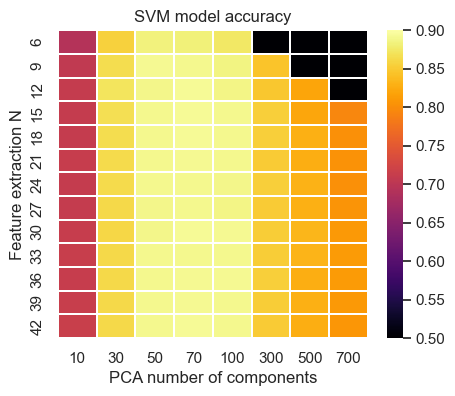

In [34]:
hm_svd = []
hm_rfc = []
for n in n_freq:
    hm_svd_n = []
    hm_rfc_n = []
    for i in i_pca:
        try:
            s_rfc = scores[(n,i)][0][1]
            s_svd = scores[(n,i)][1][1]
            hm_rfc_n.append(s_rfc)
            hm_svd_n.append(s_svd)
        except:
            hm_rfc_n.append(0)
            hm_svd_n.append(0)
        
    hm_svd.append(hm_svd_n)
    hm_rfc.append(hm_rfc_n)
    
hm = hm_svd     ### CHANGE FOR THE OTHER HEATMAP

sns.heatmap(hm, vmin = 0.50, vmax=0.90, cmap='inferno', 
            xticklabels=i_pca, yticklabels=n_freq, linewidths=0.30)
plt.title("SVM model accuracy")
plt.xlabel("PCA number of components")
plt.ylabel('Feature extraction N')

In [56]:
max_comb = (15, 80) ########### AFTER MANY EXPERIMENTS THIS WAS THE BEST

### Object classifier hyperparameter tuning

In [57]:
#BEST: {'C': 5, 'kernel': 'rbf'}
print(max_comb)
n_max, i_max = max_comb

X_ft = pd.read_csv(f"preprocess/freq_n/{n_max}_bins.csv")
X_mfcc = pd.read_csv(f"preprocess/mfcc_n/{n_max}_bins.csv")
X_tot = np.hstack((X_ft, X_mfcc))
    
pca = PCA(n_components=i_max)
X_pca = pca.fit_transform(X_tot)

(15, 80)


In [58]:
### SVM
params = {
    "C": [1,5,10,50,100],
    "kernel": ["rbf"]#,"linear","sigmoid"] 
}

accuracies = []
for config in ParameterGrid(params):
    print(config, end="")
    clf = Pipeline([('scaler', StandardScaler()), ('SVM', svm.SVC(**config))])
    acc = cross_val_score(clf, X_pca, y_obj, cv=5).mean()
    accuracies.append(acc)
    print(acc)

{'C': 1, 'kernel': 'rbf'}0.8951648527490006
{'C': 5, 'kernel': 'rbf'}0.903423552401572
{'C': 10, 'kernel': 'rbf'}0.9026526879035248
{'C': 50, 'kernel': 'rbf'}0.9028728309965356
{'C': 100, 'kernel': 'rbf'}0.9028728309965356


In [59]:
### RFC
params = {
    "max_depth": [None,2,5,10,50],
    "criterion": ["gini","entropy"]
}

accuracies = []
for config in ParameterGrid(params):
    print(config, end="")
    clf = RFC(random_state=rs)
    acc = cross_val_score(clf, X_pca, y_obj, cv=5).mean()
        
    accuracies.append(acc)
    print(acc)


{'criterion': 'gini', 'max_depth': None}0.7526690531664966
{'criterion': 'gini', 'max_depth': 2}0.7526690531664966
{'criterion': 'gini', 'max_depth': 5}0.7526690531664966
{'criterion': 'gini', 'max_depth': 10}0.7526690531664966
{'criterion': 'gini', 'max_depth': 50}0.7526690531664966
{'criterion': 'entropy', 'max_depth': None}0.7526690531664966
{'criterion': 'entropy', 'max_depth': 2}0.7526690531664966
{'criterion': 'entropy', 'max_depth': 5}0.7526690531664966
{'criterion': 'entropy', 'max_depth': 10}0.7526690531664966
{'criterion': 'entropy', 'max_depth': 50}0.7526690531664966


### Action classifier hyperparameter tuning

In [60]:
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
X_obj = ohe.fit_transform(y_obj.reshape(-1,1)).toarray()

# BEST: {'C': 5, 'kernel': 'rbf'} -> 0.9000111526236548
n_max, i_max = max_comb

print(max_comb)


X_ft = pd.read_csv(f"preprocess/freq_n/{n_max}_bins.csv")
X_mfcc = pd.read_csv(f"preprocess/mfcc_n/{n_max}_bins.csv")
X_tot = np.hstack((X_ft, X_mfcc))
    
pca = PCA(n_components=i_max)
X_pca = pca.fit_transform(X_tot)

X_fin =np.hstack((X_pca, X_obj))

(15, 80)


In [61]:
### SVM
params = {
    "C": [1,5,10,50,100],
    "kernel": ["rbf"]#,"linear","sigmoid"]
}

accuracies = []
for config in ParameterGrid(params):
    print(config, end="")
    clf = Pipeline([('scaler', StandardScaler()), ('SVM', svm.SVC(**config))])
    acc = cross_val_score(clf, X_fin, y_act, cv=5).mean()
        
    accuracies.append(acc)
    print(acc)

{'C': 1, 'kernel': 'rbf'}0.8871273872069709
{'C': 5, 'kernel': 'rbf'}0.8997911913668994
{'C': 10, 'kernel': 'rbf'}0.8990202056446822
{'C': 50, 'kernel': 'rbf'}0.8989101947102622
{'C': 100, 'kernel': 'rbf'}0.8989101947102622


In [62]:
### RFC
params = {
    "max_depth": [None,2,5,10,50],
    "criterion": ["gini","entropy"]
}

accuracies = []
for config in ParameterGrid(params):
    print(config, end="")
    clf = RFC(random_state=rs)
    acc = cross_val_score(clf, X_fin, y_act, cv=5).mean()
        
    accuracies.append(acc)
    print(acc)

{'criterion': 'gini', 'max_depth': None}0.8474840529604155
{'criterion': 'gini', 'max_depth': 2}0.8474840529604155
{'criterion': 'gini', 'max_depth': 5}0.8474840529604155
{'criterion': 'gini', 'max_depth': 10}0.8474840529604155
{'criterion': 'gini', 'max_depth': 50}0.8474840529604155
{'criterion': 'entropy', 'max_depth': None}0.8474840529604155
{'criterion': 'entropy', 'max_depth': 2}0.8474840529604155
{'criterion': 'entropy', 'max_depth': 5}0.8474840529604155
{'criterion': 'entropy', 'max_depth': 10}0.8474840529604155
{'criterion': 'entropy', 'max_depth': 50}0.8474840529604155


# Final models and evaluation dataset

In [68]:
n_good = 15
i_good = 80

### Define the full dataset
X_ft = pd.read_csv(f"preprocess/freq_n/{n_good}_bins.csv").drop("Unnamed: 0", axis=1)
X_mfcc = pd.read_csv(f"preprocess/mfcc_n/{n_good}_bins.csv")
X_tot = np.hstack((X_ft, X_mfcc))

### Get the dataset from PCA
pca = PCA(n_components=i_good)
X_pca = pca.fit_transform(X_tot)

### DEFINE X for both object and action classifier
X_obj = X_pca

ohe = OneHotEncoder() # action classifier trains on CORRECT objects
X_ohe = ohe.fit_transform(y_obj.array.reshape(-1,1)).toarray()
X_act = np.hstack((X_pca,X_ohe))


### DEFINE Y for both object and action classifier
y = pd.read_csv("preprocess/y.csv")
y_act = y["0"]
y_obj = y["1"]

### DEFINE and TRAIN clf for both
clf_obj = Pipeline([('scaler', StandardScaler()), ('SVM', svm.SVC(C=5, kernel="rbf"))])
clf_obj.fit(X_obj, y_obj)

clf_act = Pipeline([('scaler', StandardScaler()), ('SVM', svm.SVC(C=5, kernel="rbf"))])
clf_act.fit(X_act, y_act)

Pipeline(steps=[('scaler', StandardScaler()), ('SVM', SVC(C=4))])

In [69]:
### LOAD EVAL DATASET
df = pd.read_csv("dsl_data/evaluation.csv")

wav_files = []
wav_freq = []

for i in range(len(df)):
    wav_f, wav_arr = wavfile.read(df.iloc[i].path)
    wav_files.append(wav_arr)
    wav_freq.append(wav_f)

In [74]:
### Preprocess the evaluation dataset
X_eval, _, sr, _ = preprocess(wav_files, y, wav_freq, quantile_filter=False)

### Extract features with (n,i) selected precedently
X_eval_ft = ft_mean_std(X_eval, n_good)
X_eval_mfcc = extract_mfcc(X_eval, n_good, sr)
X_eval_good = np.hstack((X_eval_ft,X_eval_mfcc))

### Use pca transform (already fitted) for the new evaluation dataset
X_pca_new = pca.transform(X_eval_good)

[15] 100.0 %


In [75]:
### Get object predictions
y_obj_pred = clf_obj.predict(X_pca_new)

In [84]:
### Define dataset for action classifier
X_ohe = ohe.fit_transform(y_obj_pred.reshape(-1,1)).toarray()
X_act = np.hstack((X_pca_new, X_ohe))

In [87]:
### Get action classifier
y_act_pred = clf_act.predict(X_act)

In [90]:
### Put together predictions and save them
y_fin_new = y_act_pred + y_obj_pred
pd.DataFrame(y_fin_new, columns=["Predicted"]).to_csv("eval.csv", index=True, index_label="Id")

# Dummy Classifier for comparison

In [91]:
dummy_df = pd.read_csv("preprocess/df_ok.csv")

dummy_X = dummy_df.drop(["object","action"], axis=1)
dummy_y = dummy_df["action"]+dummy_df["object"]

dummy_clf = DummyClassifier(strategy="most_frequent")


acc = cross_val_score(dummy_clf, dummy_X, dummy_y, cv=5).mean()
print(f"Dummy classifier accuracy: {acc}")

Dummy classifier accuracy: 0.2499724821133737
